# Predicting Pathogen from RNAseq data

## Create the model using hyperparameter tuning

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   35.7s finished


Best: -1.099814 using {'n_estimators': 1, 'max_depth': 1}
-1.099814 (0.011303) with: {'n_estimators': 1, 'max_depth': 1}
-1.112787 (0.029429) with: {'n_estimators': 3, 'max_depth': 1}
-1.135678 (0.042911) with: {'n_estimators': 5, 'max_depth': 1}
-1.165098 (0.052897) with: {'n_estimators': 7, 'max_depth': 1}
-1.198807 (0.060203) with: {'n_estimators': 9, 'max_depth': 1}
-1.099814 (0.011303) with: {'n_estimators': 1, 'max_depth': 3}
-1.112787 (0.029429) with: {'n_estimators': 3, 'max_depth': 3}
-1.135678 (0.042911) with: {'n_estimators': 5, 'max_depth': 3}
-1.165098 (0.052897) with: {'n_estimators': 7, 'max_depth': 3}
-1.198807 (0.060203) with: {'n_estimators': 9, 'max_depth': 3}
-1.099814 (0.011303) with: {'n_estimators': 1, 'max_depth': 5}
-1.112787 (0.029429) with: {'n_estimators': 3, 'max_depth': 5}
-1.135678 (0.042911) with: {'n_estimators': 5, 'max_depth': 5}
-1.165098 (0.052897) with: {'n_estimators': 7, 'max_depth': 5}
-1.198807 (0.060203) with: {'n_estimators': 9, 'max_depth': 

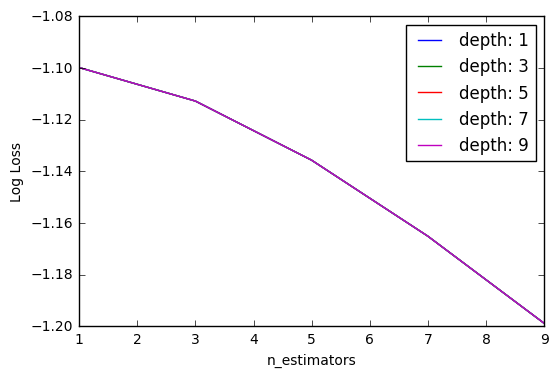

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

patient_groups=["control", "viral", "bacterial"]

X = pd.DataFrame.from_csv("combineSV_cutoff_WTcpmtable.txt", sep="\s+").T
y = [patient_groups.index("bacterial")] * 17 \
    + [patient_groups.index("viral")] * 13 \
    + [patient_groups.index("control")] * 18
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

model = XGBClassifier(objective="multi:softprob")
# Number of boosted trees to fit.
n_estimators = range(1, 11, 2)
# Maximum tree depth for base learners.
max_depth = range(1, 11, 2)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", 
                           n_jobs=1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
%matplotlib inline

scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')

## Make predictions based on the model

In [2]:
# make predictions
predicted = grid_result.predict(X_test)

print "Accuracy was %.2f%%\n" % (100 * accuracy_score(y_test, predicted))
print classification_report(y_test, predicted, target_names=patient_groups)
cm = confusion_matrix(y_test, predicted, labels=[0,1,2])
print "Confusion Matrix: rows = predictions, columns = actual\n"
row_format ="{:>15}" * (len(patient_groups)+1)
print row_format.format("", *patient_groups)
for disease, row in zip(patient_groups, cm):
    print row_format.format(disease, *row)

Accuracy was 65.00%

             precision    recall  f1-score   support

    control       0.67      0.44      0.53         9
      viral       0.57      0.80      0.67         5
  bacterial       0.71      0.83      0.77         6

avg / total       0.66      0.65      0.64        20

Confusion Matrix: rows = predictions, columns = actual

                       control          viral      bacterial
        control              4              3              2
          viral              1              4              0
      bacterial              1              0              5


## Review patients the model misclassified

In [3]:
probs = np.array(grid_result.predict_proba(X_test))
probs *= 100

d = {"Probability Control": probs[:, patient_groups.index("control")],
     "Probability Viral": probs[:, patient_groups.index("viral")],
     "Probability Bacterial": probs[:, patient_groups.index("bacterial")],
     "Predicted Class": [patient_groups[i] for i in grid_result.predict(X_test)],
     "Actual Class": [patient_groups[i] for i in y_test]}

patient_df = pd.DataFrame(d, index=X_test.index)
patient_df[patient_df["Predicted Class"] != patient_df["Actual Class"]]

,Actual Class,Predicted Class,Probability Bacterial,Probability Control,Probability Viral
MN_288,control,bacterial,36.980911,31.676357,31.342733
MNC.118,control,viral,34.987049,29.968496,35.044453
MN_381,bacterial,control,35.097836,35.155418,29.746750
MN_366,control,bacterial,36.980911,31.676357,31.342733
MN_386,control,viral,31.363350,31.638885,36.997761
MNC.354,control,viral,31.363350,31.638885,36.997761
MN_382,viral,control,35.097836,35.155418,29.746750


In [4]:
from IPython.core.display import display, HTML

colname = "Importance"
df = pd.DataFrame(grid_result.best_estimator_.booster().get_score(importance_type="weight"),
                  index=[colname]).T
df = df[df[colname] > 0]
df = df.sort_values(by=[colname], ascending=False)

s="""
<h2>List of genes by importance</h2>
<p>Note: the NCBI link will open the target in a new window or tab.</p>
<table>
<tr><th>Gene</th><th>Importance</th><th>NCBI</th></tr>
"""

ncbi_url = lambda gene: "https://www.ncbi.nlm.nih.gov/gene/?term=%s[Gene Name] AND Human[Organism]" % (gene)

for index, row in df.iterrows():
    s += """
    <tr><td>%s</td><td>%d</td>
    <td><a target=\"_blank\" href=\"%s\">NCBI Search</a></td></tr>
    """ %(index, row[0], ncbi_url(index))
s += "</table>"

display(HTML(s))


Gene,Importance,NCBI
CISD3,1,NCBI Search
FYN,1,NCBI Search
IL2RB,1,NCBI Search


In [7]:
# Dump booster info
grid_result.best_estimator_.booster().get_dump()

['0:[CISD3<33.2943] yes=1,no=2,missing=1\n\t1:leaf=-0.0564706\n\t2:leaf=0.1\n',
 '0:[IL2RB<121.106] yes=1,no=2,missing=1\n\t1:leaf=-0.0670588\n\t2:leaf=0.1\n',
 '0:[FYN<102.912] yes=1,no=2,missing=1\n\t1:leaf=0.0983607\n\t2:leaf=-0.0652174\n']